# $\S 1$ Solutions of linear equations 
---

In this lab, I will test three algorithms of solving linear equations about their correctness and efficiency, they are: 
- Principle Component Method
- Jacobi Iteration ALgorithm
- Gauss-Seidel Iteration Algorithm  
and to compare the two iteration method we choose the norm difference as the loss of our algorihtm: 
given iteration fomular of simple iteration method(1, 2):
$$
x^{(k+1)} = Bx^{(k)} + g \tag{1}
$$
we get: 
$$
e(x^{(k)}) = {||B||\over 1-||B||} ||x^{(k)}-x^{(k-1)}|| \tag{2}
$$
proof is given in ppt of the course. 
And then use these algorithms to solve the problem 1, 2 in instruction book. 

## 1. realization of these algorithms 

In [77]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg

In [78]:
def jacobi_B_g(A, b):  # calculate B firstly and then calculate g 
    D = np.diag(np.diag(A))
    L_U = A - D
    D_inv = np.linalg.inv(D)
    B = -D_inv @ L_U
    g = D_inv @ b
    return B, g

def gauss_seidel_B_g(A, b):  # calculate B firstly and then calculate g 
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    D_L_inv = np.linalg.inv(D + L)
    B = -D_L_inv @ U
    g = D_L_inv @ b
    return B, g

def loss(B, x_new, x):
    """
    Calculates the loss of x_new (norm 2 here)

    Args:
    - B: numpy array of shape (n,)
    - x_new: numpy array of shape (n,)
    - x: numpy array of shape (n,)

    Returns:
    - float representing the loss
    """
    
    norm_B = np.linalg.norm(B, 2)  # calculate the norm of B
    if norm_B >= 1:  # if norm of B is greater than 1, the algorithm did not converge 
        return -1
    diff_x = np.linalg.norm(x_new - x, 2)  # calculate the norm of the difference between x_new and x
    error = norm_B / (1 - norm_B) * diff_x
    return error

### 1.1. Principle Component Method (optimization of gauss elimination method)

In [79]:
def PCM(A, b):
    """
    Performs Gaussian elimination on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A: numpy array of shape (n, n) representing the coefficient matrix
    - b: numpy array of shape (n,) representing the constant vector
    
    Returns:
    - numpy array of shape (n,) representing the solution vector x
    """
    n = len(A)
    M = A.copy()
    b_copy = b.copy()
    
    for k in range(n):
        # find principle element 
        maxindex = abs(M[k:,k]).argmax() + k
        
        # swap 
        if k != maxindex:
            M[[k,maxindex]] = M[[maxindex, k]]
            b_copy[[k,maxindex]] = b_copy[[maxindex, k]]
            
        # elimination 
        for row in range(k+1, n):
            multiplier = M[row][k]/M[k][k]
            M[row][k:] = M[row][k:] - multiplier*M[k][k:]
            b_copy[row] = b_copy[row] - multiplier*b_copy[k]
    
    # back substitution
    x = np.zeros(n)
    for k in range(n-1, -1, -1):
        x[k] = (b_copy[k] - np.dot(M[k,k+1:], x[k+1:])) / M[k,k]
    return x

### 1.2. Jacobi Iteration (simple iteration method)

iteration formular: 
$$
x_{i}^{k+1} = {{b_{i} - \sum_{j=1}^{i-1} A_{ij} x_{j}^{k} - \sum_{j=i+1}^{n} A_{ij} x_{j}^{k}} \over A_{ii}} \tag{3}
$$

In [80]:
def jacobi(A, b, tol=1e-6, max_iter=1000):
    """
    Performs Jacobi iteration on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A: numpy array of shape (n, n) representing the coefficient matrix
    - b: numpy array of shape (n,) representing the constant vector
    - tol: float representing the tolerance for convergence
    - max_iter: int representing the maximum number of iterations

    Returns:
    - numpy array of shape (n,) representing the solution vector x
    - list of float representing the norm of the difference between x_new and x
    """
    n = len(b)
    x = np.zeros(n)
    ll = []
    x_new = np.zeros(n)
    B, _ = jacobi_B_g(A, b)

    if loss(B, x_new, x) < 0:  # not converge
        raise ValueError('Jacobi method did not converge')

    for _ in range(max_iter):
        for i in range(n):
            # calculate x_new
            x_new[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i] 

        iloss = loss(B, x_new, x)
        ll.append(iloss)  # calculate the error by the norm of the difference between x_new and x
        if iloss < tol:  # check if the error is less than the tolerance
            break
        x = np.copy(x_new)
    return x, ll
    raise ValueError('Jacobi method did not converge')

### 1.3. Gauss Seidel (optimized iteration method)
iteration formular: 
$$
x_{i}^{k+1} = {{b_{i} - \sum_{j=1}^{i-1} A_{ij} x_{j}^{k} - \sum_{j=i+1}^{n} A_{ij} x_{j}^{k+1}} \over A_{ii}} \tag{4}
$$

In [81]:
def gauss_seidel(A, b, tol=1e-6, max_iter=1000):
    """
    Performs Gauss-Seidel iteration on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A: numpy array of shape (n, n) representing the coefficient matrix
    - b: numpy array of shape (n,) representing the constant vector
    - tol: float representing the tolerance for convergence
    - max_iter: int representing the maximum number of iterations

    Returns:
    - numpy array of shape (n,) representing the solution vector x
    - list of float representing the norm of the difference between x_new and x
    """
    n = len(b)
    x = np.zeros(n)
    ll = []
    x_new = np.zeros(n)
    B, _ = gauss_seidel_B_g(A, b)

    if loss(B, x_new, x) < 0: # not converge
        raise ValueError('Gauss-Seidel method did not converge')

    for _ in range(max_iter):
        for i in range(n):
            # calculate x_new
            x_new[i] = (b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i] 

        iloss = loss(B, x_new, x)
        ll.append(iloss)  # calculate the error by the norm of the difference between x_new and x
        if iloss < tol:  # check if the error is less than the tolerance
            break
        x = np.copy(x_new)
    return x, ll
    raise ValueError('Gauss-Seidel method did not converge')

I will use the loss as metric to visualize the convergency of algorithm. 

In [82]:
def visualize(A, b):
    plt.figure(figsize=(12, 6))
    _, ll2 = jacobi(A, b)
    _, ll3 = gauss_seidel(A, b)
    plt.plot(np.arange(len(ll2)), np.array(ll2), label="Jacobi")
    plt.plot(np.arange(len(ll3)), np.array(ll3), label="Gauss-Seidel")
    plt.ylabel("Loss")
    plt.xlabel("Iteration")
    plt.title("Convergency of Jacobi and Gauss-Seidel")
    plt.legend()
    plt.show()

## 2. test and analysis of these algorithms

To test these algorithms, we use some well-tested packages of python to calculate the same linear equations and compare the results. 

here is an example: 

Solution             : [ 0.1754365 -0.0206160  0.1626760  0.2330266 -0.0822191]
PCM solution         : [ 0.1754365 -0.0206160  0.1626760  0.2330266 -0.0822191]
Jacobi solution      : [ 0.1754364 -0.0206161  0.1626759  0.2330265 -0.0822191]
Gauss-Seidel solution: [ 0.1754363 -0.0206163  0.1626760  0.2330265 -0.0822190]


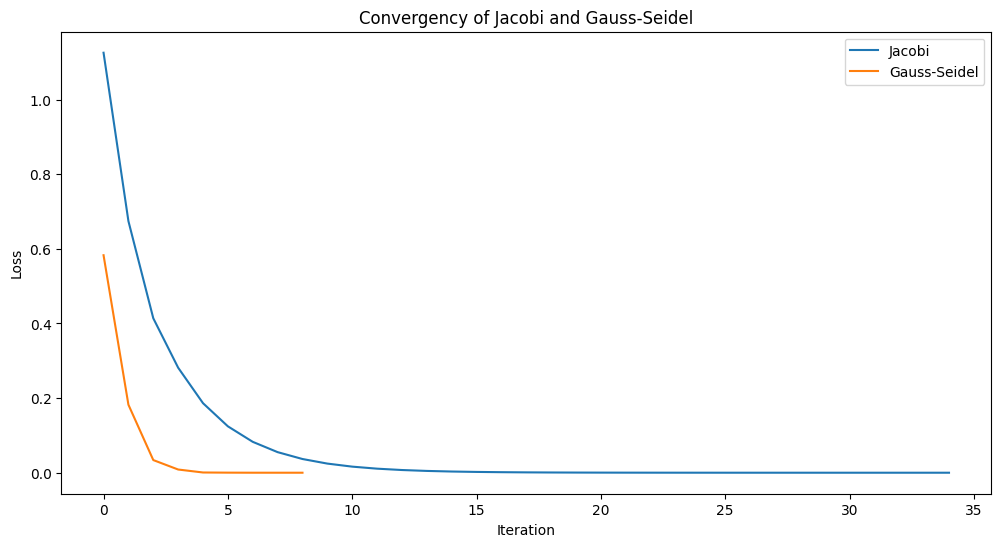

In [83]:
# Coefficient matrix and constant vector
A = np.array([
        [3.18646561, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 2.44752548, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 3.04954371, 0.21233911, 0.18182497],
        [0.18340451, 0.30424224, 0.52475643, 2.16752236, 0.29122914],
        [0.61185289, 0.13949386, 0.29214465, 0.36636184, 2.32199322]])
b = np.array(
        [0.78517596, 0.19967378, 0.51423444, 0.59241457, 0.04645041])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group
sol2, _ = jacobi(A, b)
sol3, _ = gauss_seidel(A, b)

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f"Solution             : {sol0}")
print(f"PCM solution         : {sol1}")
print(f"Jacobi solution      : {sol2}")
print(f"Gauss-Seidel solution: {sol3}")

# Visualization of iteration methods
visualize(A, b)

<center> Figure 1: comparison between Jacobi Algorithm and Gauss-Seidel Algorithm

as we can see from the result, PCM method get the precise solution and the latter two get the approximate solution. And from the **Figure 1**, we can see that Jacobi Method convergences slower than the Gauss-Seidel Method. 

Further more, I guess that the advantages will be more obvious with the incresing of data scale. So, I will test it by random matrix. 

# 3. solution of problems 

## 3.1. problem 1

In [84]:
A = np.array([[1.1348, 3.8326, 1.1651, 3.4017],
              [0.5301, 1.7875, 2.5330, 1.5435],
              [3.4129, 4.9317, 8.7643, 1.3142],
              [1.2371, 4.9998, 10.6721, 0.0147]])
b = np.array([9.5342, 6.3941, 18.4231, 16.9237])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f"Solution             : {sol0}")
print(f"PCM solution         : {sol1}")


Solution             : [1.0000000 1.0000000 1.0000000 1.0000000]
PCM solution         : [1.0000000 1.0000000 1.0000000 1.0000000]


Solution             : [1.1000000 1.2000000 1.3000000]
PCM solution         : [1.1000000 1.2000000 1.3000000]
Jacobi solution      : [1.0999992 1.1999992 1.2999990]
Gauss-Seidel solution: [1.0999983 1.1999989 1.2999994]


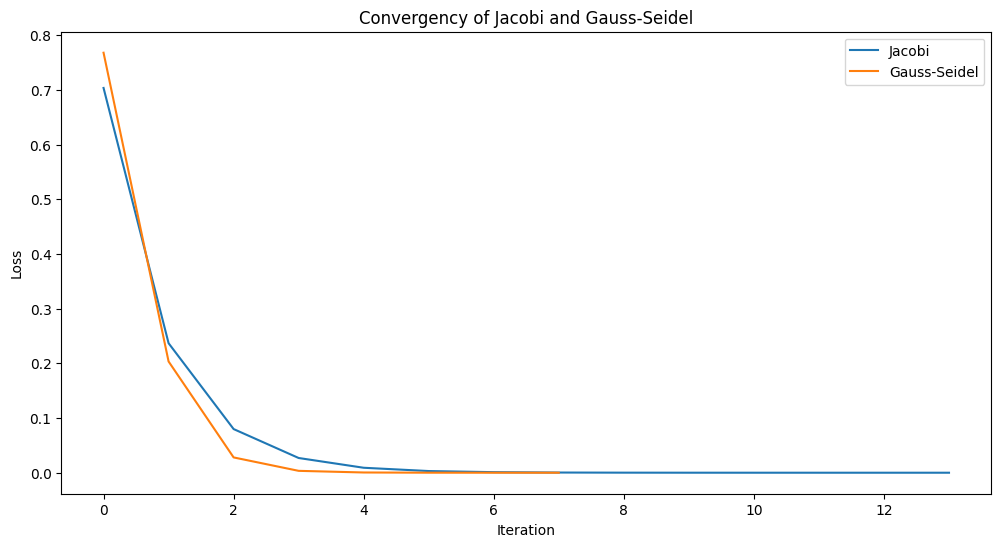

In [85]:

A = np.array([[10, -1, -2.0],
              [-1, 10, -2],
              [-1, -1, 5]])
b = np.array([7.2, 8.3, 4.2])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group
sol2, _ = jacobi(A, b)
sol3, _ = gauss_seidel(A, b)

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f"Solution             : {sol0}")
print(f"PCM solution         : {sol1}")
print(f"Jacobi solution      : {sol2}")
print(f"Gauss-Seidel solution: {sol3}")

visualize(A, b)